In [1]:
import wandb
import numpy as np
import torch
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from diff_ts import EpsilonTheta
from diff_ts import GaussianDiffusion

In [11]:
run = wandb.init(project="test_train_2")
artifact = run.use_artifact('fyp_a/test_train_2/model_batch256_lr0.01_e500:v0')
artifact_dir = artifact.download()
model=GaussianDiffusion(EpsilonTheta([256]), input_size = 256)
model.load_state_dict(torch.load(f"{artifact_dir}/model_batch256_lr0.01_e500.pth"))

model.eval()

all_generated_signals = []


total_signals = 10000
batch_size = 256 

with torch.no_grad():  
    for _ in range(total_signals // batch_size):
        noise_shape = (batch_size, 1, 256) 
        random_noise = torch.randn(noise_shape, device=model.betas.device)
        generated_signals_batch = model.p_sample_loop(random_noise)
        
        # Convert generated signals to CPU and detach from the computation graph
        generated_signals_batch = generated_signals_batch.cpu().detach()
        
        # Append the generated batch to the list
        all_generated_signals.append(generated_signals_batch.numpy())  # Convert to numpy for easier handling

# Concatenate all batches to form a single dataset
generated_signals = np.concatenate(all_generated_signals, axis=0)

wandb:   1 of 1 files downloaded.  


In [9]:
file_path = 'C:/Users/Alexia/datasets/train_set.pth'
dataset = torch.load(file_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=None)

original_signals = []

# Iterate through your DataLoader
for i, data in enumerate(train_loader):
    signals = data['signals']  
    for signal in signals:
        # Flatten the signal and convert to numpy array
        flattened_signal = signal.squeeze().cpu().numpy()
        original_signals.append(flattened_signal)

# Convert list of numpy arrays to a single numpy array
real_signals = np.stack(original_signals)

KL Divergence between generated and real signals: 2.4721482306942284


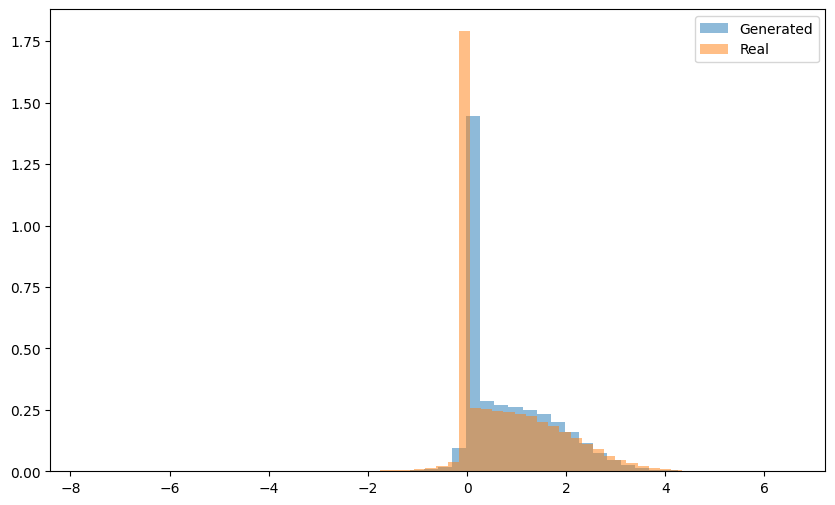

In [10]:



def calculate_kl_divergence(p, q):
    """
    Calculate the KL divergence between two distributions.
    Note: Both p and q should sum to 1.
    """
    q = np.where(q == 0, np.finfo(float).eps, q)
    return entropy(p, q)

def approximate_pdf(signals, bins=50, range=None):
    """
    Approximate the PDF of signals using histograms.
    """
    counts, bin_edges = np.histogram(signals, bins=bins, range=range, density=True)
    pdf = counts / sum(counts)
    return pdf, bin_edges



# Flatten the signal arrays for PDF approximation
generated_signals_flat = generated_signals.reshape(-1)
real_signals_flat = real_signals.reshape(-1)# Adjust as necessary

# Approximate the PDFs of the generated and real signals
generated_pdf, _ = approximate_pdf(generated_signals_flat)
real_pdf, _ = approximate_pdf(real_signals_flat) # Adjust as necessary

# Calculate the KL divergence between the two PDFs
kl_divergence = calculate_kl_divergence(real_pdf, generated_pdf)

print(f"KL Divergence between generated and real signals: {kl_divergence}")


plt.figure(figsize=(10, 6))
plt.hist(generated_signals_flat, bins=50, alpha=0.5, label='Generated', density=True)
plt.hist(real_signals_flat, bins=50, alpha=0.5, label='Real', density=True) # Adjust as necessary
plt.legend()
plt.show()
